In [1]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [15]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *
import pickle
from datetime import datetime

In [4]:
# Load the pre-split data

store = pd.HDFStore('/home/dissertation/data/dfs_abt_split.h5')
X_train, X_test, y_train, y_test = store['X_train'], store['X_test'], store['y_train'], store['y_test']
store.close()

# Drop msno from the dataset
X_train.drop(['msno', 'registration_init_time', 'registration_init_time_dt'], inplace=True, axis=1, errors='ignore')
X_test.drop(['msno', 'registration_init_time', 'registration_init_time_dt'], inplace=True, axis=1, errors='ignore')

print("Train Shape:", X_train.shape, y_train.shape)
print("Train Shape:", X_test.shape, y_test.shape)
X_train.head()

Train Shape: (600803, 164) (600803,)
Train Shape: (257487, 164) (257487,)


,bd,city,gender,registered_via,SUM(transactions.payment_plan_days),SUM(transactions.plan_list_price),SUM(transactions.actual_amount_paid),SUM(transactions.transaction_date),SUM(transactions.membership_expire_date),SUM(transactions.price_difference),...,DIFF(MAX(transactions.planned_daily_price)),DIFF(MAX(transactions.daily_price)),DIFF(STD(transactions.payment_plan_days)),DIFF(STD(transactions.plan_list_price)),DIFF(STD(transactions.actual_amount_paid)),DIFF(STD(transactions.transaction_date)),DIFF(STD(transactions.membership_expire_date)),DIFF(STD(transactions.price_difference)),DIFF(STD(transactions.planned_daily_price)),DIFF(STD(transactions.daily_price))
551174,28,5,male,3,180,298.00,894.00,120923653,120924153,428.00,...,1.67,1.67,0.00,76.94,0.00,3890.64,3353.08,55.25,2.56,0.00
403333,20,13,male,3,127,627.00,627.00,100812365,100812869,0.00,...,1.03,1.03,9.96,42.15,71.37,-1967.03,-2345.67,-20.98,1.41,2.33
594889,18,13,male,3,540,2682.00,2682.00,362862440,362881912,0.00,...,0.00,0.00,0.00,-29.22,0.00,-371.25,-554.29,-20.98,-0.97,0.00
100379,0,1,unknown,7,547,2384.00,2682.00,382888820,383039868,214.00,...,0.00,0.00,4.90,21.64,34.18,-2480.05,344.36,9.19,0.73,1.08
207602,35,13,female,7,720,2529.00,2956.00,483713706,483807163,341.00,...,0.00,0.00,0.00,44.20,19.09,-1495.13,-544.06,38.55,1.47,0.64


In [5]:
RANDOM_STATE = 42 
CV_ITER = None
SCORING_METRIC = autosklearn.metrics.recall
BASE_NAME = "askbasic_" + str(CV_ITER) + "cv_" + str(SCORING_METRIC)
N_JOBS = 2
## Time periods to train for in minutes
# TIME_PERIODS = [0.25, 0.5, 1, 2, 3, 4]
TIME_PERIODS = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]

## Set the list of the categorical columns in the dataset
cat_col= ['gender', 'city', 'registered_via']

df_cols = X_train.columns
feat_types =  ['Categorical' if col in cat_col else 'Numerical' for col in df_cols]

classifiers = []

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]    
for period in TIME_PERIODS:
    classifiers.append(
        ('ASKLEARN_{}_'.format(str(period)) + BASE_NAME,                        ## ModelName
         autosklearn.classification.AutoSklearnClassifier(                      ## Model  
                time_left_for_this_task=int(60*period), 
                n_jobs=N_JOBS,
                include_estimators=["random_forest", "decision_tree", "adaboost", "gaussian_nb",
                                    "liblinear_svc", "xgradient_boosting"], 
                exclude_estimators=None,
                include_preprocessors=["no_preprocessing", ], 
                exclude_preprocessors=None,
                ml_memory_limit = 3072*9), 
         {},                                                                    ## HyperParams
         SCORING_METRIC)                                                        ## ScoringMetric 
    )

In [6]:
all_metrics = pd.DataFrame()
all_results = list()

In [7]:
# with open('/tmp/dfsask_all_metrics.pickle', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     all_metrics = pickle.load(f)

# with open('/tmp/dfsask_all_results.pickle', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     all_results = pickle.load(f)

In [ ]:
# # Write (overwrite) the file to store the experiment results
# with open('/tmp/dfsask_all_metrics.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     print("Writing results to", f.name)
#     pickle.dump(all_metrics, f, pickle.HIGHEST_PROTOCOL)
    
# # Write (overwrite) the file to store the experiment results
# with open('/tmp/dfsask_all_results.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     print("Writing results to", f.name)
#     pickle.dump(all_results, f, pickle.HIGHEST_PROTOCOL)

### Experiment 1.1 Baseline - Default Settings - No sampling

In [ ]:
%%time
start = time.time()

sampler = ('None', DummySampler())

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [19]:
all_metrics[['sampling_method']].drop_duplicates()

,sampling_method
0,RUS 1:1
0,None
0,ROS 3:1
0,ROS 2:1
0,ROS 1:1
0,ROS 3:2
0,SMOTE_NC


In [ ]:
all_metrics[['label','sampling_method']].groupby(['sampling_method']).count()

In [ ]:
all_metrics.groupby('sampling_method').train_time.sum()/60/60

### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

In [ ]:
%%time
start = time.time()

sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

In [ ]:
%%time
start = time.time()

sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [ ]:
all_metrics

In [ ]:
# sys.getsizeof(model)
# model = all_results[0][2][0][-1]
# print(model.sprint_statistics())
# print(model.show_models())

### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [ ]:
all_metrics.sampling_method.value_counts()

In [ ]:
all_metrics.sort_values(['balanced_accuracy', 'recall'], ascending=[False, False]).head()

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col, auto_ml = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

### Experiment 1.7 Baseline Default Settings SMOTE-NC

In [12]:
sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,8,13,14], n_jobs=8))

X_train_t, X_test_t, y_train_t, y_test_t = \
    prepare_train_test_data(X_train, X_test, y_train, y_test, 
                            sampler = RandomOverSampler(random_state=RANDOM_STATE), 
                            cat_col = cat_col)

PRE-SAMPLING: (600803, 164) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (1089322, 164) (1089322,) Counter({1: 544661, 0: 544661})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['gender', 'city', 'registered_via']
Categorical columns in dataset ['gender', 'city', 'registered_via']
X_train:  (1089322, 187) (1089322, 1)
X_test:  (257487, 187) (257487, 1)


Model Build Iteration 0
Training ASKLEARN_10_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 10:05:22,744:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:05:22,955:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:05:24,961:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:05:26,968:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:05:28,975:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:05:30,981:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:05:32,996:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


-1
['/tmp/autosklearn_tmp_8604_9957/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_8604_9957/.auto-sklearn/ensembles/1791095845.0000000001.ensemble']
Generating test scores for ASKLEARN_10_askbasic_Nonecv_recall classifier
Training ASKLEARN_15_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 10:15:44,836:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:15:44,948:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:15:46,952:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:15:48,959:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:15:50,965:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:15:52,972:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:15:54,977:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

-1
['/tmp/autosklearn_tmp_8604_8732/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_8604_8732/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_8604_8732/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_8604_8732/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_8604_8732/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_8604_8732/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_8604_8732/.auto-sklearn/ensembles/1791095845.0000000006.ensemble']
Generating test scores for ASKLEARN_15_askbasic_Nonecv_recall classifier
Training ASKLEARN_20_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 10:31:22,420:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:31:22,476:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:31:24,483:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:31:26,490:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:31:28,497:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:31:30,504:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:31:32,508:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


-1
['/tmp/autosklearn_tmp_8604_8100/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_8604_8100/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_8604_8100/.auto-sklearn/ensembles/1791095845.0000000002.ensemble']
Generating test scores for ASKLEARN_20_askbasic_Nonecv_recall classifier
Training ASKLEARN_25_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 10:51:46,845:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:51:47,074:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 10:51:49,127:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:51:56,606:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:51:58,612:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:52:00,618:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:52:02,625:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:52:04,675:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 10:52:06,682:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 11:16:01,731:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-17 11:16:01,731:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
-1
['/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095845.0000000003.ensemble']
Generating test scores for ASKLEARN_25_askbasic_Nonecv_recall classifier
Training ASKLEARN_30_askbasic_Nonecv_recall classifier
No params set, using Standard training


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 11:17:20,202:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:17:20,254:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:17:22,260:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:17:24,267:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:17:26,272:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:17:28,279:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:17:30,343:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

[WARNING] [2019-08-17 11:42:33,029:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-17 11:42:33,029:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


-1
['/tmp/autosklearn_tmp_8604_3517/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_8604_3517/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_8604_3517/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_8604_3517/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_8604_3517/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_8604_3517/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_8604_3517/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_8604_3517/.auto-sklearn/ensembles/1791095845.0000000007.ensemble', '/tmp/autosklearn_tmp_8604_3517/.auto-sklearn/ensembles/1791095845.0000000008.ensemble', '/tmp/autosklearn_tmp_8604_3517/.auto-sklearn/ensembles/1791095845.0000000009.ensemble', '/tmp/autosklearn_tmp_8604_3517/.auto-sklearn/ensembles/1791095845.0000000010.ensemble', '/tmp/autosklearn

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 11:48:24,318:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:48:24,518:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:48:26,549:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:48:28,556:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:48:30,563:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:48:32,570:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 11:48:34,577:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

[WARNING] [2019-08-17 12:13:34,727:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-17 12:13:34,727:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


-1
['/tmp/autosklearn_tmp_8604_3363/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_8604_3363/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_8604_3363/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_8604_3363/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_8604_3363/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_8604_3363/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_8604_3363/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_8604_3363/.auto-sklearn/ensembles/1791095845.0000000007.ensemble', '/tmp/autosklearn_tmp_8604_3363/.auto-sklearn/ensembles/1791095845.0000000008.ensemble', '/tmp/autosklearn_tmp_8604_3363/.auto-sklearn/ensembles/1791095845.0000000009.ensemble', '/tmp/autosklearn_tmp_8604_3363/.auto-sklearn/ensembles/1791095845.0000000010.ensemble', '/tmp/autosklearn

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 12:24:50,860:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 12:24:50,938:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 12:24:52,944:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 12:24:54,950:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 12:24:57,021:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 12:24:59,053:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 12:25:01,072:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

[WARNING] [2019-08-17 12:50:02,314:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-17 12:50:02,314:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


-1
['/tmp/autosklearn_tmp_8604_1961/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_8604_1961/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_8604_1961/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_8604_1961/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_8604_1961/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_8604_1961/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_8604_1961/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_8604_1961/.auto-sklearn/ensembles/1791095845.0000000007.ensemble', '/tmp/autosklearn_tmp_8604_1961/.auto-sklearn/ensembles/1791095845.0000000008.ensemble', '/tmp/autosklearn_tmp_8604_1961/.auto-sklearn/ensembles/1791095845.0000000009.ensemble', '/tmp/autosklearn_tmp_8604_1961/.auto-sklearn/ensembles/1791095845.0000000010.ensemble', '/tmp/autosklearn

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 13:06:06,295:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 13:06:06,430:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 13:06:08,472:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 13:06:10,477:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 13:06:12,484:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 13:06:14,491:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 13:06:16,498:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 13:06:18,505:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 13:06:20,512:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 13:31:25,449:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-17 13:31:25,449:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

[WARNING] [2019-08-17 13:50:18,440:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-17 13:50:18,440:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
-1
['/tmp/autosklearn_tmp_8604_1614/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_8604_1614/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_8604_1614/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_8604_1614/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_8604_1614/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_8604_1614/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_8604_1614/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_8604_1614/.auto-sklearn/ensembles/1791095

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[CRITICAL] [2019-08-17 13:53:08,896:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] Changing ensemble score for file /tmp/autosklearn_tmp_8604_8375/.auto-sklearn/predictions_ensemble/predictions_ensemble_1872583848_2.npy from 0.593145 to 0.593145 because file modification time changed? 1566031964.671333 - 1566042788.266794


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[CRITICAL] [2019-08-17 13:53:49,701:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] Changing ensemble score for file /tmp/autosklearn_tmp_8604_8375/.auto-sklearn/predictions_ensemble/predictions_ensemble_1872583848_3.npy from 0.571121 to 0.607811 because file modification time changed? 1566032009.623470 - 1566042828.350919


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[CRITICAL] [2019-08-17 14:01:03,689:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] Changing ensemble score for file /tmp/autosklearn_tmp_8604_8375/.auto-sklearn/predictions_ensemble/predictions_ensemble_1872583848_8.npy from 0.742785 to 0.707542 because file modification time changed? 1566032961.162634 - 1566043262.088298


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 14:17:31,169:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-17 14:17:31,169:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

[WARNING] [2019-08-17 14:41:23,471:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-17 14:41:23,471:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
-1
['/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_8604_8375/.auto-sklearn/ensembles/1791095

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 14:43:14,913:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 14:43:15,326:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 14:43:20,893:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 14:43:22,934:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 14:43:24,941:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 14:43:26,947:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 14:43:28,954:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 14:43:30,960:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 14:43:32,966:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 15:08:33,429:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-17 15:08:33,429:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 15:11:35,407:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

[WARNING] [2019-08-17 15:37:26,152:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-17 15:37:26,152:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
-1
['/tmp/autosklearn_tmp_8604_9442/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_8604_9442/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_8604_9442/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_8604_9442/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_8604_9442/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_8604_9442/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_8604_9442/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_8604_9442/.auto-sklearn/ensembles/1791095

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-08-17 15:39:17,831:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 15:39:17,897:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 15:39:19,903:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 15:39:21,909:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 15:39:23,916:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 15:39:25,923:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than random - using Dummy Score!
[WARNING] [2019-08-17 15:39:27,936:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] No models better than

/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

[WARNING] [2019-08-17 15:58:05,325:EnsembleBuilder(1791095845):31c09bf2b24f46c72b648af178dacdfd] Memory Exception -- restart with less ensemle_nbest: 25


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

[WARNING] [2019-08-17 16:04:32,264:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger
[WARNING] [2019-08-17 16:04:32,264:smac.intensification.intensification.Intensifier] Challenger was the same as the current incumbent; Skipping challenger


/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/anaconda/envs/py373/lib/python3.7/

-1
['/tmp/autosklearn_tmp_8604_7432/.auto-sklearn/ensembles/1791095845.0000000000.ensemble', '/tmp/autosklearn_tmp_8604_7432/.auto-sklearn/ensembles/1791095845.0000000001.ensemble', '/tmp/autosklearn_tmp_8604_7432/.auto-sklearn/ensembles/1791095845.0000000002.ensemble', '/tmp/autosklearn_tmp_8604_7432/.auto-sklearn/ensembles/1791095845.0000000003.ensemble', '/tmp/autosklearn_tmp_8604_7432/.auto-sklearn/ensembles/1791095845.0000000004.ensemble', '/tmp/autosklearn_tmp_8604_7432/.auto-sklearn/ensembles/1791095845.0000000005.ensemble', '/tmp/autosklearn_tmp_8604_7432/.auto-sklearn/ensembles/1791095845.0000000006.ensemble', '/tmp/autosklearn_tmp_8604_7432/.auto-sklearn/ensembles/1791095845.0000000007.ensemble']
Generating test scores for ASKLEARN_60_askbasic_Nonecv_recall classifier


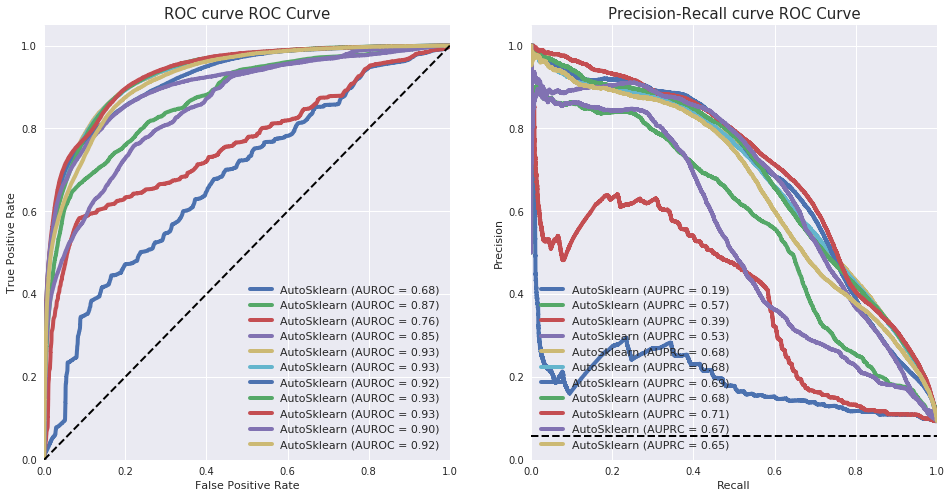

CPU times: user 16min 54s, sys: 3min 21s, total: 20min 15s
Wall time: 6h 34min 14s


In [17]:
%%time
start = time.time()
sampler = ('SMOTE_NC', DummySampler())

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'bd', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times']

exp_metrics, model_results = perform_experiment(X_train_t, X_test_t, y_train_t, y_test_t, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=[], auto_ml = False, 
                                                n_jobs = 4, prepare_data = False)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("basic, autosklearn, {0}, {1}".format(sampler[0], time.time()-start), 'Basic_Autosklearn.log')

In [ ]:
all_metrics.sort_values('recall', ascending=False).head(15)

In [20]:
#store(all_results, 'Asklearn_Default_Undersample.pickle')

# Write (overwrite) the file to store the experiment results
with open('DFS_Asklearn_20190818.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    print("Writing results to", f.name)
    pickle.dump(all_results, f, pickle.HIGHEST_PROTOCOL)

Writing results to DFS_Asklearn_20190818.pickle


In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)